In [1]:
import os.path
import numpy as np
import iris
import biggus
from pp_utils import TimedBlock

# Demo : Team 2(a) "Dask *in* Biggus"

Rationale leverage Dask abilities for Iris : 

**One way**
a-la Phil : co-opt key Dask technology (the scheduler) *into* Biggus  --> Team 2(b) ...

**Another way**
We "might" like to rework Iris to use Dask in place of Biggus
but there are a lot of obstacles to that.

So...

Replace little parts of Biggus with Dask operation "under the hood".
Repeat until Biggus is a "thin shell"
(then consider moving the 'thin' code into Iris + retiring Biggus altogether)

key benefit of this approach : it's incremental

## Proof of concept : content
* provide `biggus.DaskArrayAdapter` : [code](https://github.com/SciTools/biggus/pull/201/files#diff-af00232ad38479c19d961792c64ad8c2R1490)
* 'divert' `biggus.NumpyArrayAdapter` ***to*** that 
 * --> Iris PP-loading creates `DaskArrayAdapter(PPDataProxy(field))`
* 'divert' biggus.ArrayStack on dask input : [code](https://github.com/SciTools/biggus/pull/201/files#diff-af00232ad38479c19d961792c64ad8c2R1767)
 * `stack([daskadapter*...])` --> `daskadapter(dask-stack)`
* 'divert' biggus.mean on dask input : [code](https://github.com/SciTools/biggus/pull/201/files#diff-af00232ad38479c19d961792c64ad8c2R2878)
 * `mean(daskadapter)` --> `daskadapter(dask-mean)`

## Here's what we get ...

In [2]:
f0 = '/data/local/dataZoo/PP/ppmnvar/agkfca.pyy0c10.pp'
p1 = iris.load_cube(f0, iris.AttributeConstraint(STASH=iris.fileformats.pp.STASH.from_msi('m01s00i407')))

/home/h05/itpp/git/iris/iris_main/lib/iris/fileformats/rules.py:946: UserWarning: Unable to create instance of HybridHeightFactory. The source data contains no field(s) for 'orography'.
  warnings.warn(msg.format(factory=factory_name))


In [3]:
print
print 'source data from one file : 38 * levels = fields.'
print
print p1
print
print
print 'LAZY? ', p1.has_lazy_data()


source data from one file : 38 * levels = fields.

air_pressure / (Pa)                 (model_level_number: 38; latitude: 145; longitude: 192)
     Dimension coordinates:
          model_level_number                           x             -               -
          latitude                                     -             x               -
          longitude                                    -             -               x
     Auxiliary coordinates:
          level_height                                 x             -               -
          sigma                                        x             -               -
     Scalar coordinates:
          forecast_period: 4507920.0 hours, bound=(4503600.0, 4512240.0) hours
          forecast_reference_time: 1978-09-01 00:00:00
          time: 2500-06-01 00:00:00, bound=(2499-12-01 00:00:00, 2500-12-01 00:00:00)
     Attributes:
          STASH: m01s00i407
          source: Data from Met Office Unified Model
          um_version: 

In [4]:
p1._my_data

<DaskArrayAdapter shape=(38, 145, 192) dtype=dtype('float32')>

In [5]:
p1._my_data.concrete

dask.array<stack-d..., shape=(38, 145, 192), dtype=float32, chunksize=(1, 145, 192)>

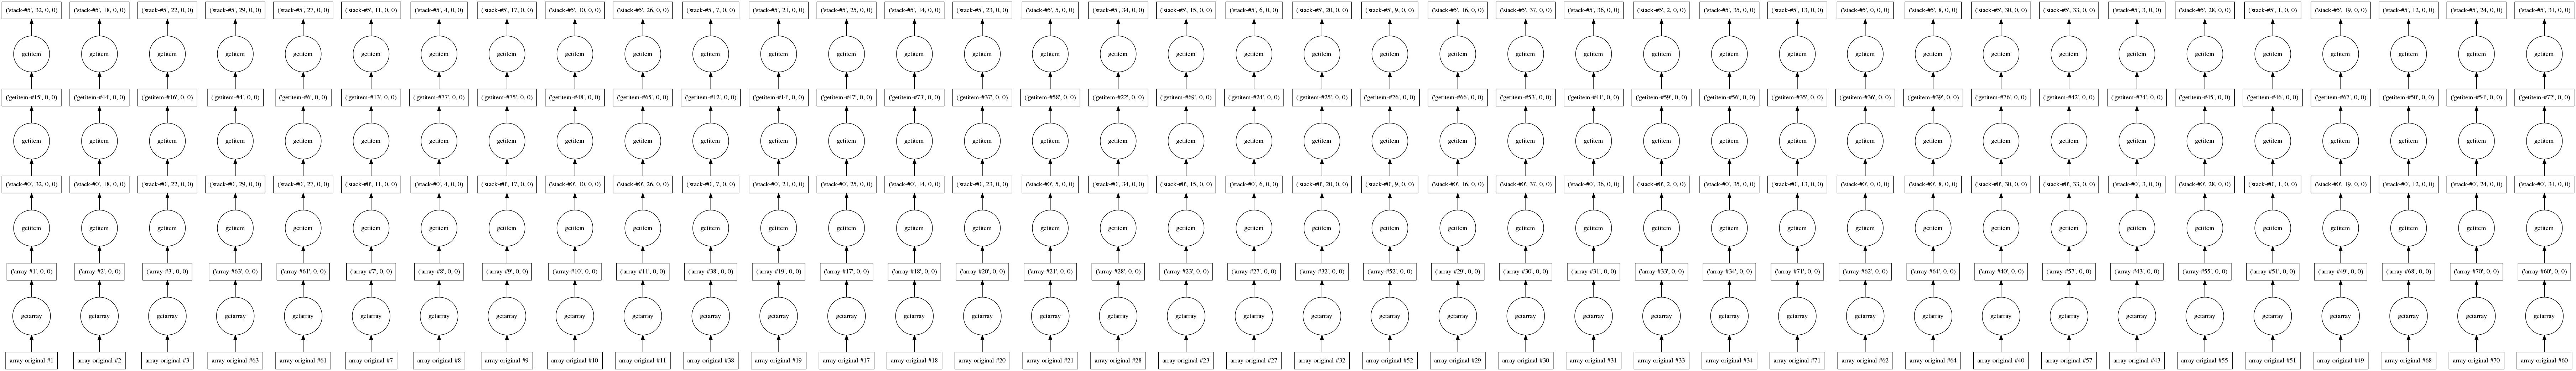

In [6]:
# Show a Dask graph of the load.
if 0:
    # TO FILE...
    graph_path = os.path.join(dirpath, 'dask_load_graph.png')
    p1._my_data.concrete.visualize(graph_path)

# In notebook
p1._my_data.concrete.visualize()

### See result [dask_load_graph.png](http://www-avd/~itpp/biggus_dask_demo/dask_load_graph.png) 

In [7]:
# Now do a statistical operation
pn_mean = p1.collapsed('model_level_number', iris.analysis.MEAN)

/home/h05/itpp/git/iris/iris_main/lib/iris/coords.py:993: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'model_level_number'.
  warnings.warn(msg.format(self.name()))


In [8]:
print
print 'mean over level:'
print
print pn_mean
print
print
print 'LAZY? ', pn_mean.has_lazy_data()


mean over level:

air_pressure / (Pa)                 (latitude: 145; longitude: 192)
     Dimension coordinates:
          latitude                           x               -
          longitude                          -               x
     Scalar coordinates:
          forecast_period: 4507920.0 hours, bound=(4503600.0, 4512240.0) hours
          forecast_reference_time: 1978-09-01 00:00:00
          level_height: 19627.4 m, bound=(0.0, 39254.8) m
          model_level_number: 19, bound=(1, 38)
          sigma: 0.5, bound=(0.0, 1.0)
          time: 2500-06-01 00:00:00, bound=(2499-12-01 00:00:00, 2500-12-01 00:00:00)
     Attributes:
          STASH: m01s00i407
          source: Data from Met Office Unified Model
          um_version: 6.1
     Cell methods:
          mean: time (1 hour)
          mean: model_level_number


LAZY?  True


In [9]:
pn_mean._my_data

<DaskArrayAdapter shape=(145, 192) dtype=dtype('float32')>

In [10]:
pn_mean._my_data.concrete

dask.array<mean_ag..., shape=(145, 192), dtype=float32, chunksize=(145, 192)>

In [ ]:
# Show a Dask graph of the mean result.
if 0:
    # actually, this one takes a while (!) ...
    graph_path = os.path.join(dirpath, 'dask_mean_graph.png')
    pn_mean._my_data.concrete.visualize(graph_path)

### See result [dask_mean_graph.png](http://www-avd/~itpp/biggus_dask_demo/dask_mean_graph.png) 

## So, what's the point ?

At present, little.

But this provides an incremental route to get Dask "into" Iris

Right now:
 * provide a simple means to wrap Dask-coded function
 * less work to extend operations *via* Biggus
 * can do things that we "never got around to" in Biggus
    * additional statistics
    * better parallel evaluation

Potential:
 * distribute / parallel evaluation
   * even loading will be useful : 'automatic' process parallelisation on file loads



## FOR EXAMPLE: multidimensional mean calculation

Biggus ***can't*** do this ...

In [ ]:
# Load 2 pp files
fn = ['/data/local/dataZoo/PP/ppmnvar/agkfca.pyy0c10.pp',
      '/data/local/dataZoo/PP/ppmnvar/agkfca.pyy1c10.pp']

# N.B. there are 10 of these (different times)

pn = iris.load_cube(fn, iris.AttributeConstraint(STASH=iris.fileformats.pp.STASH.from_msi('m01s00i407')))

print
print 'multi-file load (10 files = 10 time points * 38 levels):'
print
print pn
print
print 'LAZY? ', pn.has_lazy_data()

In [ ]:
print pn._my_data
print pn._my_data.concrete

### result [big_dask_load_graph.png](http://www-avd/~itpp/biggus_dask_demo/big_dask_load_graph.png) 

In [ ]:
# Do a mean over 2 dimensions
pn_mean = pn.collapsed(['time', 'model_level_number'], iris.analysis.MEAN)

print
print 'multi-file load (10 files = 10 time points * 38 levels):'
print
print pn_mean
print
print 'LAZY? ', pn_mean.has_lazy_data()

In [ ]:
print pn_mean._my_data
print pn_mean._my_data.concrete

In [ ]:
# Calculate ...
print pn_mean[10:12, 20:23].data

### result [big_dask_mean_graph.png](http://www-avd/~itpp/biggus_dask_demo/big_dask_mean_graph.png) 

## What's the catch ?

What Dask doesn't  yet have that Iris really needed ...

**Notably**: mask support


## Resources
Stuff to run this ...
 * biggus : [branch](https://github.com/pp-mo/biggus/tree/dask_morestuff) [latest_good_version](https://github.com/pp-mo/biggus/tree/245acff1b3cc5a01eacfa9eab9fb4b31202ce029)
   * (Note: links here are to the previous commit, but this commit is needed to make the last example work)
 * iris : [branch](https://github.com/pp-mo/iris/tree/multidim_agg)
   * just the last commit : fix needed to allow Iris to *attempt* a multidimensional collapse.
   * this is a design bug really : It "should" be Biggus to say whether it supports multiple axes or not ...
 * environment : create with conda...
   * `conda create -n iris_dask python=2.7 dask ipython-notebook graphviz --file=~itpp/git/iris/iris_main/conda_requirements.txt`
   * `pip install graphviz`
